## Experiment with cutting up models


In [1]:
from datetime import datetime
from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import *
import fastai
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from string import ascii_uppercase
import numpy as np
import operator
import glob

import torch
from torch import nn as nn
from torch.nn import functional as F

import copy


# %matplotlib inline

# %matplotlib widget

plt.rcParams['figure.figsize'] = [9, 5]
plt.rcParams['figure.dpi'] = 120
plt.style.use('dark_background')

from fastai.tabular.all import *
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")
def label_func(f): return f[0].isupper()
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224), bs=32)





In [2]:
def fit_slide(self:Learner, n_epoch, lr_max=None, div=25., div_final=1e5, pct_start=0.25, wd=None,
                  moms=None, cbs=None, reset_opt=False):
    "Fit `self.model` for `n_epoch` using the 1cycle policy."
    if self.opt is None: self.create_opt()
    self.opt.set_hyper('lr', self.lr if lr_max is None else lr_max)
    
    lr_max = np.array([h['lr'] for h in self.opt.hypers])
    
#     f = combine_scheds([0.1,0.1, 0.05, 0.05,0.2, 0.5], 
#                    [SchedCos(lr_max*0.8,lr_max*1.0), 
#                     SchedLin(lr_max*1.0,lr_max*1.0), 
#                     SchedCos(lr_max*1.0, lr_max*0.75), 
#                     SchedCos(lr_max*0.75, lr_max*0.95), 
#                     SchedCos(lr_max*0.95,lr_max*0.9), 
#                     SchedCos(lr_max*0.9,lr_max/div_final)])
    
    f = combine_scheds([1], [SchedLin(lr_max*1.0, lr_max/div_final)])
    
    scheds = {'lr': f}
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd)

In [3]:
def fit_hump(self:Learner, n_epoch, lr_max=None, div=25., div_final=1e5, pct_start=0.25, wd=None,
                  moms=None, cbs=None, reset_opt=False):
    "Fit `self.model` for `n_epoch` using the 1cycle policy."
    if self.opt is None: self.create_opt()
    self.opt.set_hyper('lr', self.lr if lr_max is None else lr_max)
    
    
    lr_max = np.array([h['lr'] for h in self.opt.hypers])
    
    f = combine_scheds([0.1,0.1, 0.05, 0.05,0.2, 0.5], 
                   [SchedCos(lr_max*0.8,lr_max*1.0), 
                    SchedLin(lr_max*1.0,lr_max*1.0), 
                    SchedCos(lr_max*1.0, lr_max*0.75), 
                    SchedCos(lr_max*0.75, lr_max*0.95), 
                    SchedCos(lr_max*0.95,lr_max*0.9), 
                    SchedCos(lr_max*0.9,lr_max/div_final)])
    
    scheds = {'lr': f,
              'mom': combined_cos(pct_start, *(self.moms if moms is None else moms))}
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd)

In [4]:
def fit_hump_nomo(self:Learner, n_epoch, lr_max=None, div=25., div_final=1e5, pct_start=0.25, wd=None,
                  moms=None, cbs=None, reset_opt=False):
    "Fit `self.model` for `n_epoch` using the 1cycle policy."
    if self.opt is None: self.create_opt()
    self.opt.set_hyper('lr', self.lr if lr_max is None else lr_max)
    lr_max = np.array([h['lr'] for h in self.opt.hypers])
        
    f = combine_scheds([0.1,0.1, 0.05, 0.05,0.2, 0.5], 
                   [SchedCos(lr_max*0.8,lr_max*1.0), 
                    SchedLin(lr_max*1.0,lr_max*1.0), 
                    SchedCos(lr_max*1.0, lr_max*0.75), 
                    SchedCos(lr_max*0.75, lr_max*0.95), 
                    SchedCos(lr_max*0.95,lr_max*0.9), 
                    SchedCos(lr_max*0.9,lr_max/div_final)])
    
    scheds = {'lr': f}
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd)

In [5]:
class SwishAutoFn(torch.autograd.Function):
    """Swish - Described in: https://arxiv.org/abs/1710.05941
    Memory efficient variant from:
     https://medium.com/the-artificial-impostor/more-memory-efficient-swish-activation-function-e07c22c12a76
    """
    @staticmethod
    def forward(ctx, x):
        result = x.mul(torch.sigmoid(x))
        ctx.save_for_backward(x)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_tensors[0]
        x_sigmoid = torch.sigmoid(x)
        return grad_output.mul(x_sigmoid * (1 + x * (1 - x_sigmoid)))


def swish_auto(x, inplace=False):
    # inplace ignored
    return SwishAutoFn.apply(x)


class SwishAuto(nn.Module):
    def __init__(self, inplace: bool = True):
        super(SwishAuto, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return SwishAutoFn.apply(x)


class MishAutoFn(torch.autograd.Function):
    """Mish: A Self Regularized Non-Monotonic Neural Activation Function - https://arxiv.org/abs/1908.08681
    Experimental memory-efficient variant
    """

    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        y = x.mul(torch.tanh(F.softplus(x)))  # x * tanh(ln(1 + exp(x)))
        return y

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_tensors[0]
        x_sigmoid = torch.sigmoid(x)
        x_tanh_sp = F.softplus(x).tanh()
        return grad_output.mul(x_tanh_sp + x * x_sigmoid * (1 - x_tanh_sp * x_tanh_sp))


def mish_auto(x, inplace=False):
    # inplace ignored
    return MishAutoFn.apply(x)


class MishAuto(nn.Module):
    def __init__(self, inplace: bool = True):
        super(MishAuto, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return MishAutoFn.apply(x)

In [6]:


from torch.utils.checkpoint import checkpoint, checkpoint_sequential

class CheckpointModule(Module):
    def __init__(self, module, num_segments=1):
        assert num_segments == 1 or isinstance(module, nn.Sequential)
        self.module = module
        self.num_segments = num_segments

    def forward(self, *inputs):
        if self.num_segments > 1:
            return checkpoint_sequential(self.module, self.num_segments, *inputs)
        else:
            return checkpoint(self.module, *inputs)
        
        

# To extract the sequential layers from resnet
def layer_config(arch):
    "Get the layers associated with `arch`."
    return model_layers.get(arch)


model_layers = {
    resnet18 :[2, 2, 2, 2], resnet34: [3, 4, 6, 3],
    resnet50 :[3, 4, 6, 3], resnet101:[3, 4, 23, 3],
    resnet152:[3, 8, 36, 3]}



    
def convert_seq_chkpt(model, layer_type_old):  #, num_chkpt):
#     seg_dict = {2:2, 3:6, 4:5, 5:5, 6:3, 7:3, 8:2, 1:1}
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = convert_seq_chkpt(module, layer_type_old) #, num_chkpt+1)

        if type(module) == layer_type_old:
#             num_chkpt += 1
            layer_old = module
            if len(layer_old) == 7:
                segments = 1
            else: segments = len(layer_old)
            layer_new = CheckpointModule(layer_old, segments)  # wrap sequential in a checkpoint module
            model._modules[name] = layer_new
#             print(num_chkpt)  # 2,3,4,5,6,7,8,1
#             print(len(layer_old))

    return model

import kornia
def convert_MP_to_blurMP(model, layer_type_old):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = convert_MP_to_blurMP(module, layer_type_old)

        if type(module) == layer_type_old:
            layer_old = module
            layer_new = kornia.contrib.MaxBlurPool2d(3, True)
            model._modules[name] = layer_new

    return model


def convert_act_cls(model, layer_type_old, layer_type_new):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = convert_act_cls(module, layer_type_old, layer_type_new)

        if type(module) == layer_type_old:
            layer_old = module
            layer_new = layer_type_new
            model._modules[name] = layer_new

    return model


from timm import create_model
from fastai.vision.learner import _update_first_layer

def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='', memory_efficient=True )
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")
        
def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3, init=nn.init.kaiming_normal_, custom_head=None,
                     concat_pool=False, **kwargs):
    "Create custom architecture using `arch`, `n_in` and `n_out` from the `timm` library"
    body = create_timm_body(arch, pretrained, None, n_in)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children())) * (2 if concat_pool else 1)
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model


def timm_learner(dls, arch:str, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dls` and `arch` using the `timm` library"
    if config is None: config = {}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_timm_model(arch, n_out, default_split, pretrained, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, splitter=default_split, **kwargs)
    if pretrained: learn.freeze()
    return learn

In [7]:
# arch = xse_resnext34(pretrained=True, act_cls=MishAuto, sa=True)
# # arch.pretrained = True
# # arch.act_cls=Mish
gradacc_cb =  GradientAccumulation(n_acc=128)
reduceLR_cb = ReduceLROnPlateau(monitor='valid_loss', min_delta=0.01, min_lr=1e-8, patience=2, factor=15, reset_on_fit=True)

cbs=[ShowGraphCallback()] #, GradientClip, gradacc_cb]

# model = Learner(dls, model=arch, 
#                     loss_func=LabelSmoothingCrossEntropyFlat(), cbs=cbs, opt_func=ranger,
#                metrics=[accuracy])

In [8]:
## from https://github.com/prigoyal/pytorch_memonger/blob/master/models/optimized/densenet_new.py

import torch
import torch.nn as nn
import torch.nn.functional as F
import pdb, math
from torch.utils.checkpoint import checkpoint_sequential
from collections import OrderedDict
import os, time, sys
from subprocess import Popen, PIPE

__all__ = ['DenseNet', 'densenet100', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'densenet264']

def densenet100(pretrained=False, **kwargs):
    r"""Densenet-100 model"""
    model = DenseNet(num_init_features=64, growth_rate=12, block_config=(6, 12, 24, 16),
                     **kwargs)
    return model

def densenet121(pretrained=False, **kwargs):
    r"""Densenet-121 model"""
    model = DenseNet(num_init_features=64, growth_rate=32, block_config=(6, 12, 24, 16),
                     **kwargs)
    return model


def densenet161(pretrained=False, **kwargs):
    r"""Densenet-161 model"""
    model = DenseNet(num_init_features=96, growth_rate=48, block_config=(6, 12, 36, 24),
                     **kwargs)
    return model


def densenet169(pretrained=False, **kwargs):
    r"""Densenet-169 model"""
    model = DenseNet(num_init_features=64, growth_rate=32, block_config=(6, 12, 32, 32),
                     **kwargs)
    return model


def densenet201(pretrained=False, **kwargs):
    r"""Densenet-201 model"""
    model = DenseNet(num_init_features=64, growth_rate=32, block_config=(6, 12, 48, 32),
                     **kwargs)
    return model


def densenet264(pretrained=False, **kwargs):
    r"""Densenet-264 model"""
    model = DenseNet(num_init_features=64, growth_rate=32, block_config=(6, 12, 64, 48),
                     **kwargs)
    return model


class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.add_module('norm_1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu_1', nn.ReLU(inplace=True)),
        self.add_module('conv_1', nn.Conv2d(num_input_features, bn_size *
                        growth_rate, kernel_size=1, stride=1, bias=False)),
        self.add_module('norm_2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu_2', nn.ReLU(inplace=True)),
        self.add_module('conv_2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                        kernel_size=3, stride=1, padding=1, bias=False)),
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet(nn.Module):
    r"""Densenet-BC model class"""
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000):
        super(DenseNet, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            num_input_features = num_features
            for j in range(num_layers):
                layer = _DenseLayer(
                    num_input_features + j * growth_rate, growth_rate, bn_size, drop_rate)
                self.features.add_module('denseblock{}_layer{}'.format((i + 1), (j + 1)), layer)

            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        self.features.add_module('norm5', nn.BatchNorm2d(num_features))
        self.classifier = nn.Linear(num_features, num_classes)  # We'll add our own head

    def forward(self, x, chunks=0):
        modules = [module for k, module in self._modules.items()][0]
        input_var = x.detach()
        input_var.requires_grad = True
        if chunks > 1:
            input_var = checkpoint_sequential(modules, chunks, input_var)
        else:
            input_var = checkpoint(modules, input_var)
        input_var = F.relu(input_var, inplace=True)
        input_var = F.avg_pool2d(input_var, kernel_size=7, stride=1).view(input_var.size(0), -1)
        input_var = self.classifier(input_var)
        return input_var




In [ ]:
# m = nn.Sequential(densenet100(pretrained=True, num_classes=100), create_head(200, 5))
# model = Learner(dls, m, opt_func=ranger, metrics=[accuracy])
model = Learner(dls, densenet100(pretrained=False, num_classes=2), opt_func=ranger, metrics=accuracy, cbs=cbs)

In [ ]:
# model.unfreeze()
lr_min, lr_steep = model.lr_find()
plt.axvline(x=lr_min, color='red', ls='--')
plt.axvline(x=lr_steep, color='yellow', ls='--')

In [ ]:

# fit_hump(model, 100, lr_max=7e-3)
# fit_slide(model, 10, lr_max=1e-3, reset_opt=True)
model.fit_flat_cos(10, 9e-3, pct_start=0.9999, reset_opt=True)
# model.fit_flat_cos(10, 3e-4, pct_start=0.2)
# model.fit_one_cycle(10, lr_min)

In [ ]:
model.recorder.plot_sched()

In [ ]:
# model.model

In [13]:
import timm
# model = timm_learner(dls,
#                     'efficientnet_b3a', opt_func=ranger,
#                      pretrained=False, cbs=cbs,
#                      metrics = [accuracy])

model = timm_learner(dls, 
                     'densenetblur121d', 
                     opt_func=ranger, 
                     pretrained=False, 
                     cbs=cbs, metrics = [accuracy])


In [ ]:
model.model

In [10]:
# model = convert_MP_to_blurMP(model, nn.MaxPool2d)  # doesn't exist!
# model.model = convert_act_cls(model.model, nn.ReLU, MishAuto())  # very expensive so we only use it on the last layers
# model.model = convert_act_cls(model.model, nn.SiLU, SwishAuto())  # replace with a lower memory version

# model.model[0] = convert_seq_chkpt(model.model[0], nn.Sequential) #, 0)  # wrap all BODY sequentials to use Gradient Checkpointing
# model.model[0] = nn.Sequential(CheckpointModule(model.model[0]))  # hack in the final checkpointmodule for the base sequence

# model = model.to_fp16()

In [ ]:
# model.model[0] = nn.Sequential(CheckpointModule(model.model[0]))  # hack in the final checkpointmodule for the base sequence


In [ ]:
# model.freeze()
# lr_min, lr_steep = model.lr_find()
# plt.axvline(x=lr_min, color='red', ls='--')
# plt.axvline(x=lr_steep, color='yellow', ls='--')

In [ ]:
# fit_hump(model, 1, lr_max=1e-2, reset_opt=True)

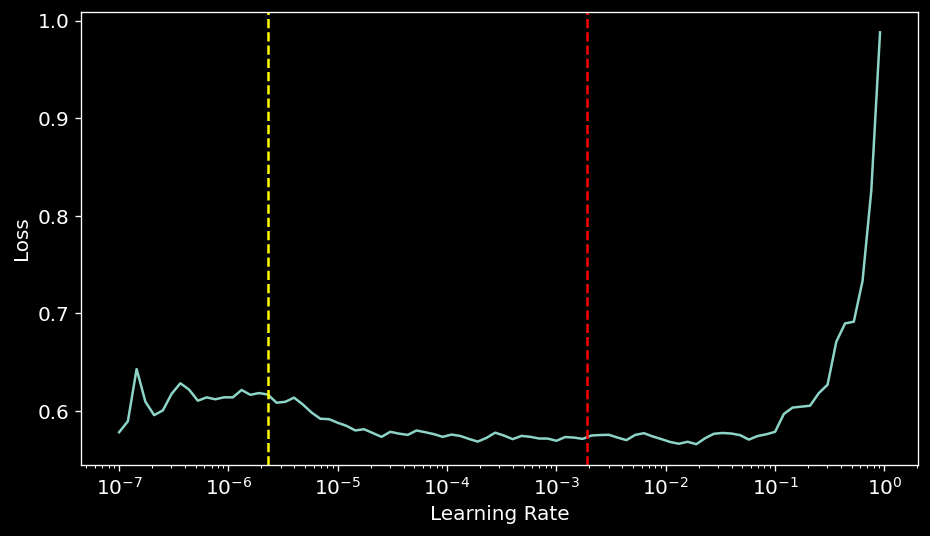

In [19]:
model.freeze()
lr_min, lr_steep = model.lr_find()
plt.axvline(x=lr_min, color='red', ls='--')
plt.axvline(x=lr_steep, color='yellow', ls='--')

epoch,train_loss,valid_loss,accuracy,time
0,0.571193,0.542739,0.725981,01:16


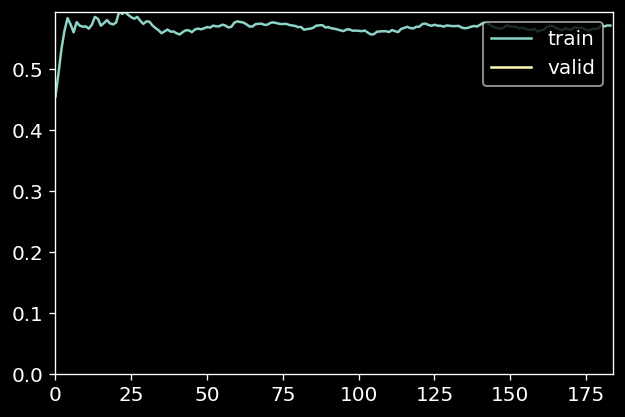

In [22]:

# fit_hump(model, 100, lr_max=7e-3)
# fit_slide(model, 10, lr_max=7e-3, reset_opt=True)
model.fit_flat_cos(1, lr_min, pct_start=0.9, reset_opt=True)
# model.fit_one_cycle(10, lr_min)

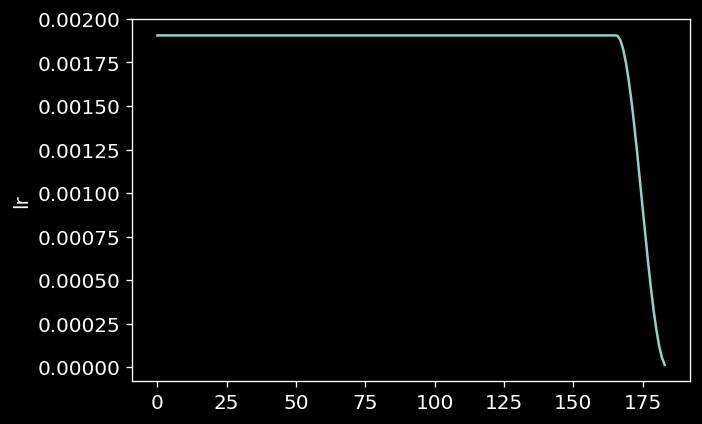

In [23]:
# fit_hump(model, 2, lr_max=lr_min, reset_opt=True)
model.recorder.plot_sched()

In [ ]:
fit_hump(model, 2, lr_max=lr_min, reset_opt=True)
model.recorder.plot_sched()

In [ ]:
model.fit_flat_cos(2, lr_min, reset_opt=True)
model.recorder.plot_sched()

In [ ]:
model.fit_one_cycle(2, lr_min, reset_opt=True)
model.recorder.plot_sched()

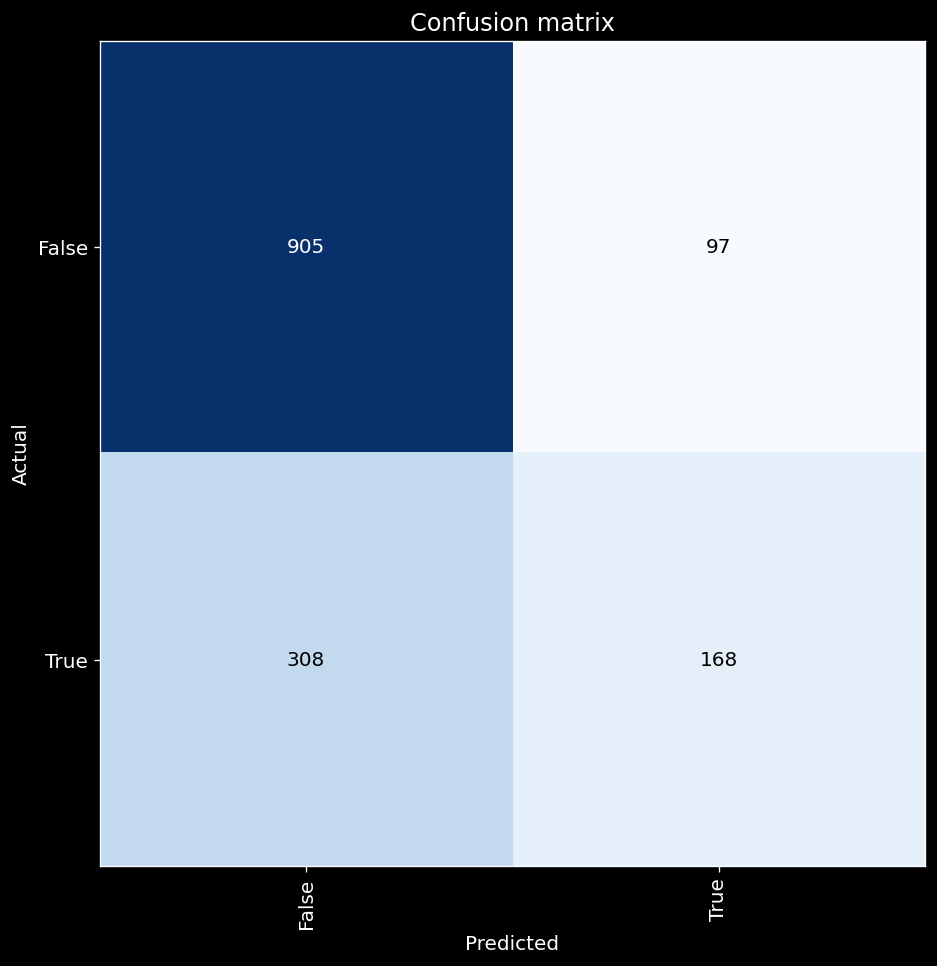

In [24]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix(figsize=(8,8))

In [25]:
interp.print_classification_report()

              precision    recall  f1-score   support

       False       0.75      0.90      0.82      1002
        True       0.63      0.35      0.45       476

    accuracy                           0.73      1478
   macro avg       0.69      0.63      0.64      1478
weighted avg       0.71      0.73      0.70      1478



In [ ]:
from fastai.test_utils import synth_learner

synth_orig = synth_learner(cbs=ShowGraphCallback(), metrics=accuracy)


In [ ]:
synth = deepcopy(synth_orig)

lr_min, lr_steep = synth.lr_find()
plt.axvline(x=1e-2, color='red', ls='--')
plt.axvline(x=1e-3, color='blue', ls='--')
plt.axvline(x=1e-1, color='purple', ls='--')

plt.axvline(x=lr_min, color='green', ls='--')
plt.axvline(x=lr_steep, color='yellow', ls='--')

In [ ]:
lr = lr_min*5

In [ ]:
synth = deepcopy(synth_orig)
synth.fit_one_cycle(10, lr_max=lr, reset_opt=True)
synth.recorder.plot_sched()

In [ ]:
synth = deepcopy(synth_orig)
fit_hump(synth, 10, lr_max=lr, reset_opt=True)
synth.recorder.plot_sched()

In [ ]:
synth = deepcopy(synth_orig)
fit_hump_nomo(synth, 10, lr_max=lr, reset_opt=True)
synth.recorder.plot_sched()

In [ ]:
synth = deepcopy(synth_orig)
synth.fit_flat_cos(10, lr=lr, reset_opt=True, cbs=ShowGraphCallback())
synth.recorder.plot_sched()